# Modélisation des ressources en eau

This notebook aims to perform an inversion of the heat transfer model in a porous medium under transient conditions based on a reference simulation sampled at 4 points. The heat transfer occurs in a portion of a one-dimensional hyporheic zone of 5 meters in height, represented by 250 cells. The difference in head between the top and bottom of the column is set to ±5 cm. The inversion will focus on the three uncertain parameters of this model, namely: 
- Intrinsic permeability ($ k $)
- Thermal conductivity of the solid ( $\lambda_s $)
- Porosity ( $\omega$)
- Heat capacity ( $C$)

We will assume (prior distribution) that these variables are independent and follow the respective distributions:

- $ -\log_{10} k \sim \mathcal{U}(10, 15)$
- $ \lambda_s \sim \mathcal{U}(1, 5) $
- $ \omega \sim \mathcal{U}(0.01, 0.25) $
- $ C \sim \mathcal{U}(1500, 3500) $

The measurement points are located along the column at positions 10 cm, 20 cm, 30 cm, and 40 cm.

In [7]:
##############################
### IMPORT ALL THE MODULES ###
##############################

# Import all the necessary files
import sys
import os

# Ajoutez le chemin au sys.path
sys.path.append('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python')

# Listez les fichiers dans le répertoire pour vérifier que Init_folders.py est présent
print("\nFichiers dans le répertoire src_python :")
print(os.listdir('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/'))

# Importez les modules
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import seaborn
import scipy.stats as ss

import array

plt.style.use('seaborn-v0_8')
sns.set_context('paper')
sns.set_style('white')

cool = sns.color_palette("coolwarm", as_cmap=True)

from Init_folders import prepare_ginette_directories, compile_ginette
import Direct_model
from Read_obs import process_obs_data
import Plot
import importlib
importlib.reload(Direct_model)
importlib.reload(Plot)
from Direct_model import setup_ginette, generate_zone_parameters, initial_conditions, boundary_conditions, run_direct_model, remove_first_two_days
from Plot import plot_obs, plot_obs_zoom, plot_compare_temperatures_obs_sim, plot_temperatures_profiles, plot_water_profiles_interpol,plot_temperature_profiles_interpol,plot_fluxes_timeseries,plot_domain,plot_temperatures_sim,plot_heat_flux_profiles_interpolated
prepare_ginette_directories('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES/')

from math import *
from tqdm import tqdm


Fichiers dans le répertoire src_python :
['Plot.py', 'Read_obs.py', 'stat_critere.py', 'Direct_model.py', 'Init_folders.py']
Current working directory: /home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES
Directory 'SENSI' created.
Directory 'OUTPUT' created.


# Initialisation des simulations

In [9]:
#######################################
### Initialisation de la simulation ###
#######################################

# size column meter
z_top = 0 # meters
z_bottom = -5 # meters
az=abs(z_top-z_bottom) # Hauteur totale de la colonne d'eau sur laquelle on travaille
n_depths = 250 # Nombre de points avec lesquels on veut travailler

# discretisation : size cell in meter
dz=az/n_depths # Espace entre chaque spatial scale/points, ici 2 cm
print('dz=',dz)
dz_obs=0.1 # Depth interval for observations

# 10 minute interval
dt = 600 # seconds

# 20 days
nb_day = 15# days
state=1 # Régime transitoire
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00") # Date de début de la simulation 

z_obs=setup_ginette(dt, state, nb_day, z_top, z_bottom, az, dz, date_simul_bg,dz_obs) # On initialise notre modèle avec les bons paramètres

# On définit les paramètres du problème

nb_zone=1 # Nombre de couche avec lesquelles on travaille 

alt_thk=0 # Altitude limite à quoi ? 

## Physical constants

# Porosité
REF_n = 0.05 # \omega

#-----------------------------------------------------------------
## Perméabilité intrinsèque [m2]  k=K*mu/(rho*g)
## K Conductivité hydraulique [m.s-1]
## Paramètres constants
### mu Viscosité [Pa.s]
### rho Densité [kg.m-3]
### g Gravité  9.81 [m2.s-1]

# k=10**REF_k
REF_k = -12 # m2 porosité 

#### constant parameters
mu = 1e-6  # Dynamic viscosity in Pa.s 
rho = 1000  # Density in kg/m^3 
g = 9.81  # Acceleration due to gravity in m/s^2
REF_l = 1.8 # Thermal conductivity W/m deg C 

# Calcul de la capacité thermique dans Ginette par la relation suivante :
#  c_pm = c_w * r_w * n * sat + c_s * r * (1-n) + c_a * r_a * n * (1-sat)
# rho_m imposé : 1000
# c_s Capacité thermique spécifique du solide
# val_c = c_s m2/s2/C. Il est conseillé de laisser cette valeur constante.
# Il n'est pas possible de calibrer les deux paramètres rho et c en même temps.
# J [kg m2 s−2]
# c_w = 4185D+00 m2/s2/C
# r_w = kg m-3itlectur
# Densité des grains solides rho_s = val_r [kg.m-3]
REF_r = 3500 # Densité de la couche 1

# On définit des data frame qui contiendront les conditions aux limites et les conditions initiales

# Define the total simulation time in seconds (20 days)
t_final = nb_day * 24 * 60 * 60  # seconds

# Create a DataFrame to store boundary condition data
df_BC = pd.DataFrame()

# Create an array of time points from 0 to t_final with a step of dt
df_BC['times'] = np.arange(0, t_final, dt)

# Pre-calculate constants
seconds_per_day = 60 * 60 * 24
seconds_per_week = 7 * seconds_per_day

# Example of a DataFrame with times and days (assuming df_BC['times'] is already created)
df_BC['days'] = df_BC['times'] / seconds_per_day

import numpy as np
import matplotlib.pyplot as plt

# On considère que la charge hydraulique varie au cours du temps (variations hebdomadaires)
# On considère que le botttom de notre colonne d'eau reste contant
# Donc la hauteur de la colonne d'eau varie avec le temps ? Pourquoi avoir une variation saisonnière ?

# Pre-calculate constants
two_pi = 2 * np.pi

# Linear temperature increase over time (0.3 degrees per day)
chg_per_day = 0.05

# Define a smooth square wave function using a sigmoid function
def smooth_square_wave(x, period): # Describe the variation of the hydraulic head over time
    return 2 / (1 + np.exp(-5 * np.sin(two_pi * x / period))) - 1

# Reduce the frequency by increasing the period : pourquoi réduire la fréquence / augmenter la période ?
reduced_period = 3 * seconds_per_week  # Double the period to reduce the frequency

# Calculate the top boundary using the smooth square wave function with reduced frequency
df_BC['h_top'] = ( 5 * smooth_square_wave(df_BC['times'], reduced_period) / 100  # Weekly fluctuation
                  + 5)  # Base temperature offset

# Set the bottom boundary to a constant value 
df_BC['h_bottom'] = 5 * np.ones_like(df_BC['times'])

# Pre-calculate constants
two_pi = 2 * np.pi

# Linear temperature increase over time (0.3 degrees per day)
deg_per_day = 0.3

# Calculate the top boundary temperature
df_BC['T_top'] = (5 * np.sin(two_pi * df_BC['times'] / seconds_per_day)  # Daily fluctuation
                  + deg_per_day * df_BC['days']  # Linear increase per day : est-ce que c'est parce que on considère que l'on est au printemps par exemple et que ça se réchauffe au fur et à mesure ?
                  + 3 * np.sin(two_pi * df_BC['times'] / seconds_per_week)  # Weekly fluctuation : que représente les weekly fluctuations ?
                  + 17)  # Base temperature offset

# Set the bottom boundary temperature to a constant value (10 degrees)
df_BC['T_bottom'] = 10 * np.ones_like(df_BC['times']) 

# Display the first few rows to check the results (optional)
print(df_BC.head())

# Ici on utilise des "fausses observations" : les observations sont en réalité modélisées

date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")

# Create the obs_temp DataFrame : on copie/colle simplement ce qu'on vient de créer dans les cellules précédentes
obs_temp = pd.DataFrame({
    'dates': date_simul_bg + pd.to_timedelta(df_BC['times'], unit='s'),
    'h_top': df_BC['h_top'],
    'h_bottom': df_BC['h_bottom'],
    'T_top': df_BC['T_top'],
    'T_bottom': df_BC['T_bottom']
})
# Display the obs_temp DataFrame
print(obs_temp)

z_obs=[-5] # Pourquoi est-ce qu'on rentre qu'une seule valeur ? Pourquoi pas plusieurs ?
initial_conditions(obs_temp, z_top, z_bottom, dz, z_obs)
# Sets up the initial conditions for the Ginette model.
# On rentre les observations, la top et bottom boundary, la cell height et les profondeurs observées
# Je comprends pas exactement ce que ça modifie, est-ce que ça crée un nouveau document ? Ça modifie des documents ?

#Parameters:
# - all_data (DataFrame): DataFrame containing the initial data.
# - z_top (float): Top boundary of the model domain.
# - z_bottom (float): Bottom boundary of the model domain.
# - dz (float): Cell height in the model domain.
# - z_obs (list): List of observation depths.

boundary_conditions(obs_temp,dt)

# Apply boundary conditions to the given data and update parameter files in transient state.
# This function reads boundary condition parameters from a file, updates the 
# boundary conditions based on the provided data, and writes the updated 
# parameters back to a new file. It also saves the charge and temperature 
# boundary conditions to separate files

# Returns: str: The updated boundary condition parameters as a string.

# On lance la simulation à proprement parlé

sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 

# On indique : 
# - La date de début de la simulation
# - La profondeur
# - L'intervalle entre chaque profondeur
# - Le nombre de milieux
# - L'épaisseur de la zone d'altération : qu'est-ce que ça va nous dire concrètement ? Au-delà c'est de la roche et il ne se passe rien ? 
# - La perméabilité k
# - La porosité n
# - La conductivité thermique
# - La densité
# - Les mêmes paramètres si on a deux couches [...]

#Returns: pd.DataFrame: A DataFrame containing the simulation time, temperatures, and corresponding dates.
# Ici c'est ce que l'on appelle sim_temp

dz= 0.02
la simulation commence à 2022-04-21 14:00:00
   times      days     h_top  h_bottom      T_top  T_bottom
0      0  0.000000  5.000000         5  17.000000        10
1    600  0.006944  5.000260         5  17.238880        10
2   1200  0.013889  5.000519         5  17.477344        10
3   1800  0.020833  5.000779         5  17.714978        10
4   2400  0.027778  5.001039         5  17.951366        10
                   dates     h_top  h_bottom      T_top  T_bottom
0    2022-04-21 14:00:00  5.000000         5  17.000000        10
1    2022-04-21 14:10:00  5.000260         5  17.238880        10
2    2022-04-21 14:20:00  5.000519         5  17.477344        10
3    2022-04-21 14:30:00  5.000779         5  17.714978        10
4    2022-04-21 14:40:00  5.001039         5  17.951366        10
...                  ...       ...       ...        ...       ...
2155 2022-05-06 13:10:00  4.950767         5  22.693454        10
2156 2022-05-06 13:20:00  4.950765         5  22.921559   

At line 1797 of file ../../../src/ginette_V2.f90 (unit = 32, file = 'E_zone.dat')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x73ef1dc23960 in ???
#1  0x73ef1dc244d9 in ???
#2  0x73ef1dc2510f in ???
#3  0x73ef1de7817b in ???
#4  0x73ef1de71684 in ???
#5  0x73ef1de722aa in ???
#6  0x5f8cdbddd51e in ???
#7  0x5f8cdbe02325 in ???
#8  0x73ef1d829d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#9  0x73ef1d829e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#10  0x5f8cdbd9a254 in ???
#11  0xffffffffffffffff in ???


FileNotFoundError: [Errno 2] No such file or directory: 'Sim_temperature_maille1_t.dat'

In [71]:
def create_obs_temp(REF_k, REF_n, REF_l, REF_r, noise) : 
    
   """ 
   Creates false observationnal data
    
   Parameters:
   - REF_k: reference parameter for permeability
   - REF_n: reference parameter for porosity
   - REF_l: reference parameter for thermal conductivity
   - REF_r: reference parameter for density
    
   Returns:
   - Dataset containing all temperatures
   """

   # Simulates data
   obs_temps1 =run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) # We generate a simulation thanks to Ginette, with the parameters set up in the previous cell
   obs_temps1 = obs_temps1.reset_index() # We reset the indexes, necessary step to avoid bugs
   obs_temps = obs_temps1

   # Perturbates data : we add a random noise at each time step and each time depth / The noise can be more or less strong thanks to the noise parameter
   obs_temps['Temp1'] = [obs_temps1['Temp1'][i] + noise*np.random.randn() for i in range(len(obs_temps1))]
   obs_temps['Temp2'] = [obs_temps1['Temp2'][i] + noise*np.random.randn() for i in range(len(obs_temps1))]
   obs_temps['Temp3'] = [obs_temps1['Temp3'][i] + noise*np.random.randn() for i in range(len(obs_temps1))]
    
   obs_temps = obs_temps.reset_index() # We reset the indexes, necessary step to avoid bugs

   plot_temperatures_sim(obs_temps, fontsize=15) # We plot our fake observations
    
   return obs_temps 

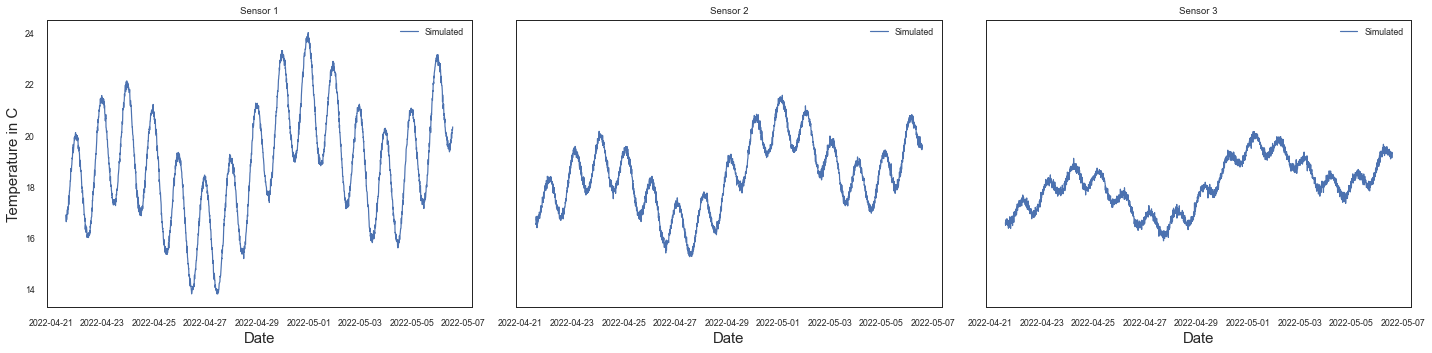

In [72]:
###########################
### CREATE OBSERVATIONS ###
###########################

noise = 0.1

REF_k = -12
REF_n = 0.05
REF_l = 1.8
REF_r = 3500

obs_temp = create_obs_temp(REF_k, REF_n, REF_l, REF_r, noise) # We create our false observationnal data

# Grid search

### GridSearch "1D" : on fait varier un paramètre après l'autre

In [32]:
# Define the misfit function
sigma = 0.2
def RMSE(sim,obs) :
    """ 
    Computes the Root Mean Square Errors

    Parameters:  
    - sim: table containing the simulation
    - obs: table containing the observations

    Returns:
    - the misfit, which is one single value
    """
    return np.sum(((sim.values-obs.values)/sigma)**2)

In [33]:
# Define the function that simulate the run and calculate the misfit function :
def grid_search_1D(para,para_list, obs_temps) :
    """ 
    Applies the grid search method in 1D by fixing all para to their reference value, except for the one we're exploring

    Parameters:  
    - para: the name of the parameter we want to explore
    - para_list : the list of values we want to explore for para
    - obs_temps: the observations

    Returns:
    - a list containing the misfit for different values tested of the parameter
    """
    
    # Create an empty list that will store the misfit
    misfit = []

    # Reference values 
    REF_k = -12
    REF_n = 0.05
    REF_l = 1.8
    REF_r = 3500

    # Distinguish the four cases possible : 
    if para == 'k' : 
        for i in tqdm(range(len(para_list))):
            sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, para_list[i], REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) # Compute a new simulation with the reference parameter and k varying
            misfit.append(RMSE(sim_temp['Temp1'],obs_temps['Temp1'])+RMSE(sim_temp['Temp2'],obs_temps['Temp2'])+RMSE(sim_temp['Temp3'],obs_temps['Temp3'])) # Computes the misfit
    
    if para == 'n' : 
        for i in tqdm(range(len(para_list))):
            sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, para_list[i], REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) # Compute a new simulation with the reference parameter and n varying
            misfit.append(RMSE(sim_temp['Temp1'],obs_temps['Temp1'])+RMSE(sim_temp['Temp2'],obs_temps['Temp2'])+RMSE(sim_temp['Temp3'],obs_temps['Temp3'])) # Computes the misfit

    if para == 'l' : 
        for i in tqdm(range(len(para_list))):
            sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, para_list[i], REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) # Compute a new simulation with the reference parameter and l varying
            misfit.append(RMSE(sim_temp['Temp1'],obs_temps['Temp1'])+RMSE(sim_temp['Temp2'],obs_temps['Temp2'])+RMSE(sim_temp['Temp3'],obs_temps['Temp3'])) # Computes the misfit
    
    if para == 'r' : 
        for i in tqdm(range(len(para_list))):
            sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, para_list[i], REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) # Compute a new simulation with the reference parameter and r varying
            misfit.append(RMSE(sim_temp['Temp1'],obs_temps['Temp1'])+RMSE(sim_temp['Temp2'],obs_temps['Temp2'])+RMSE(sim_temp['Temp3'],obs_temps['Temp3'])) # Computes the misfit

    return misfit

In [34]:
# Plot the results of the grid search in 1D
def plot_grid_search_1D(para,para_list,misfit) :

    """ 
    Plots for each para tested (x axis) the misfit (y axis) computed with grid_search_1D

    Parameters:  
    - para: the name of the parameter we want to explore
    - para_list: the list of values we want to explore for para
    - misfit: a list containing the misfit for different values tested of the parameter

    Returns:
    - a plot
    """

    fig, ax = plt.subplots(figsize=(10,5))

    logk = [log(-k[i]) for i in range(len(k))]

    ax.plot(para_list,misfit)
    ax.grid(ls='--')
    ax.set_xlabel('{}'.format(para)), 
    ax.set_ylabel('Misfit')
    ax.set_title('Misfit for different values of {}'.format(para))
    ax.legend()

    plt.show()

In [35]:
#######################################
### REFERENCE AND TESTED PARAMETERS ###
#######################################

# Define the reference parameters
REF_k = -12
REF_n = 0.05
REF_l = 1.8
REF_r = 3500

# Define the tested values
k = [-i for i in range(10,15)]
l = [0.8+i*1 for i in range(0,5)]
n = [2*i/100 for i in range(1,5)]
r = [i for i in range(2500,5000,500)]

100%|██████████| 5/5 [02:16<00:00, 27.35s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


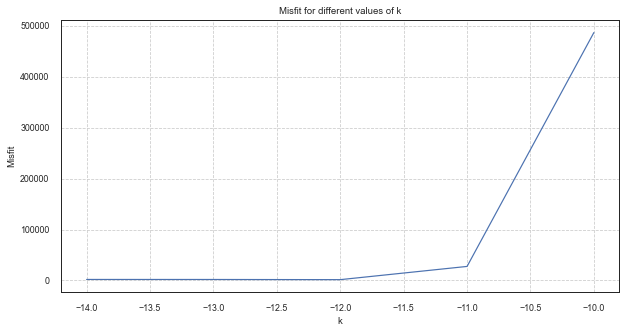

In [23]:
# Grid search in 1D for the permability k
misfit_k = grid_search_1D('k',k,obs_temp)
plot_grid_search_1D('k',k,misfit_k)

100%|██████████| 4/4 [01:24<00:00, 21.12s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


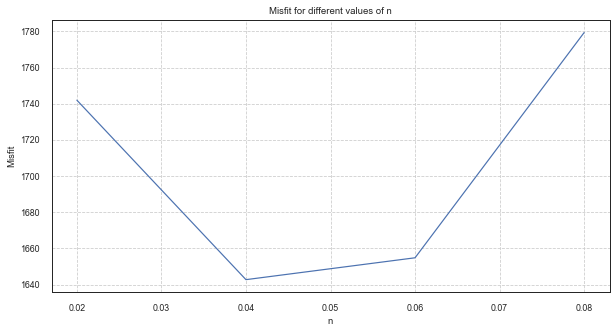

In [26]:
# Grid search in 1D for the porosity n
misfit_n = grid_search_1D('n',n,obs_temp)
plot_grid_search_1D('n',n,misfit_n)

100%|██████████| 5/5 [01:27<00:00, 17.49s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


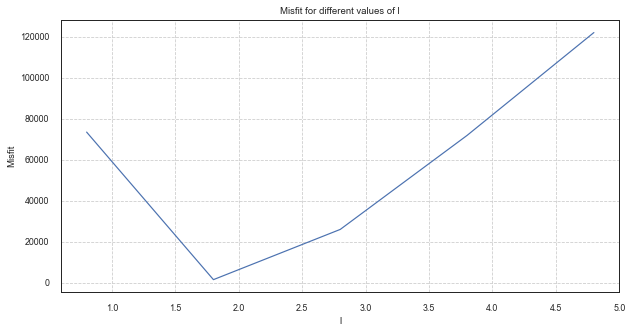

In [36]:
# Grid search in 1D for the thermal conductivity l
misfit_l = grid_search_1D('l',l,obs_temp)
plot_grid_search_1D('l',l,misfit_l)

100%|██████████| 5/5 [01:23<00:00, 16.66s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


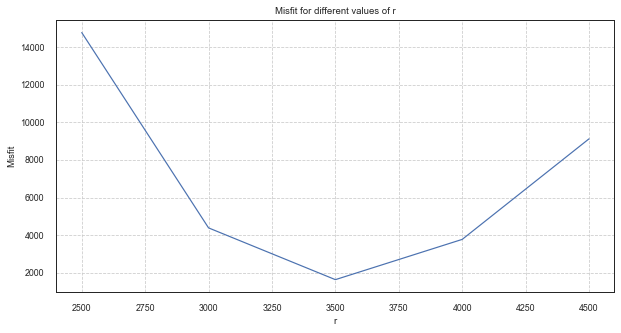

In [37]:
# Grid search in 1D for the density r
misfit_r = grid_search_1D('r',r,obs_temp)
plot_grid_search_1D('r',r,misfit_r)

### GridSearch "4D" : on fait varier tous les paramètres en même temps 
On teste 5 valeurs de chaque paramètre donc $5^4$ = 625 combinaisons 

In [38]:
# définition des fonctions erreur 

def misfit(observations, simulations, sigma_T):
    return np.sum(((observations-simulations)/sigma_T)**2)

def RMSE(observations,simulations,sigma_T):
    return np.sqrt(np.sum((observations-simulations)**2)/len(observations))/sigma_T


In [45]:
# Définition de la fonction permettant de créer les 625 combinaisons ensembles

def tableau4D() :
    """ 
    Creates a table with all the possible combinaisons for 5 values of k,n,l,r

    Parameters:  
    - ø

    Returns:
    - a table with four columns with all the possible combinaisons between the different parameters
    """
     
    # Creates a list containing all the parameters that we want to test
    k = [-i for i in range(10,15)]
    l=[0.8+i*1 for i in range(0,5)]
    n = [2*i/100 for i in range(1,6)]
    r = [i for i in range(2500,5000,500)]

    # Creates empty lists that will store the combinaisons
    k_test=[]
    n_test=[]
    l_test=[]
    r_test=[]

    # Cross all the parameters
    for a in range(len(k)) :
        for b in range(len(n)) :
            for c in range(len(l)) :
                for d in range(len(r)) :
                    k_test.append(k[a])
                    n_test.append(n[b])
                    l_test.append(l[c])
                    r_test.append(r[d])

    # Create the table
    tableau = pd.DataFrame({
        'Permeability k': k_test,
        'Porosity n': n_test,
        'Thermal conductivity l': l_test,
        'Density r': r_test,
    })

    return tableau

tableau = tableau4D()


In [59]:
def grid_search_4D(para_k,para_n,para_l,para_r,obs_temps) :

    """ 
    Applies the grid search method in 4D by testing all the different combinaisons of parameters

    Parameters:  
    - tableau: a table with four columns with all the possible combinaisons between the different parameters
    - para_k: list of all the parameters we want to test
    - para_n: list of all the parameters we want to test 
    - para_l: list of all the parameters we want to test
    - para_r: list of all the parameters we want to test


    Returns:
    - a list containing all the misfits for all the combinaisons
    """

    misfit = []   

    for i in tqdm(range(len(para_k))):
        sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, para_k[i], para_n[i], para_l[i], para_r[i], REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 
        misfit.append(RMSE(sim_temp['Temp1'],obs_temps['Temp1'])+RMSE(sim_temp['Temp2'],obs_temps['Temp2'])+RMSE(sim_temp['Temp3'],obs_temps['Temp3']))

    return misfit

In [67]:
# Define the misfit function
sigma = 0.2
def RMSE(sim,obs) :
    """ 
    Computes the Root Mean Square Errors

    Parameters:  
    - sim: table containing the simulation
    - obs: table containing the observations

    Returns:
    - the misfit, which is one single value
    """
    return np.sum(((sim.values-obs.values)/sigma)**2)

In [68]:

#########################
### GRID SEARCH IN 4D ###
#########################

para_k = list(tableau['Permeability k'])
para_n = list(tableau['Porosity n'])
para_l = list(tableau['Thermal conductivity l'])
para_r = list(tableau['Density r'])

misfit = grid_search_4D(para_k, para_n, para_l, para_r, obs_temp) # Computes the misift for all 625 combinaisons /!\ takes a dozen of hours

# Create the table
tableau_misfit = pd.DataFrame({
    'Permeability k': tableau['Permeability k'],
    'Porosity n': tableau['Porosity n'],
    'Thermal conductivity l': tableau['Thermal conductivity l'],
    'Density r': tableau['Density r'],
    'Misfit': misfit
})

# Save the table
#tableau_misfit.to_csv('/Users/leilapetit/Documents/geosciencesM2/water_ressources_model/Tableau_misfit_final.csv')

  0%|          | 1/625 [00:32<5:43:11, 33.00s/it]


KeyboardInterrupt: 

In [ ]:
# On vérifie pour quelles combinaisons de paramètres la misfit est minimale

index = tableau['Misfit'].argmin()
print('Perméabilité optimale : ', tableau['Permeability k'][index])
print('Porosité optimale :', tableau['Porosity n'][index])
print('Conductuvité thermale optimale :', tableau['Thermal conductivity l'][index])
print('Densité optimale:', tableau['Density r'][index])

In [ ]:
def marginale_misfit(df_all_combinations) :
    k = list(set(df_all_combinations['Permeability k'])) # liste qui comporte toutes les valeurs prises par le paramètre k
    n = list(set(df_all_combinations['Porosity n']))
    n.sort()
    l = list(set(df_all_combinations['Thermal conductivity l']))
    r = list(set(df_all_combinations['Density r']))
    misfit_k = []
    misfit_n = []
    misfit_l = []
    misfit_r = []
    for i in range(len(k)) :
        misfit_k.append(sum(df_all_combinations['Misfit'].where(df_all_combinations['Permeability k']==k[i]).dropna()))
    for i in range(len(n)) :
        misfit_n.append(sum(df_all_combinations['Misfit'].where(df_all_combinations['Porosity n']==n[i]).dropna()))
    for i in range(len(l)) :
        misfit_l.append(sum(df_all_combinations['Misfit'].where(df_all_combinations['Thermal conductivity l']==l[i]).dropna()))
    for i in range(len(r)) :
        misfit_r.append(sum(df_all_combinations['Misfit'].where(df_all_combinations['Density r']==r[i]).dropna()))
    return misfit_k, misfit_n, misfit_l, misfit_r


# fonction pour créer des dataframes de taille n x n avec en colonnes les valeurs de l'un des paramètres que l'on fait varier (n valeurs différentes), en lignes les valeurs d'un autre paramètre
# le dataframe donne la misfit pour chaque couple de valeurs 
# renvoie une liste de 6 dataframes, un pour chaque couple, dans l'ordre : kn, kl ,kr, nl, nr, lr    
def GS_2D_misfit(df_all_combinations, n): # n le nombre de valeurs testées pour chaque paramètre
    df_2D_misfit_list = []
    A = [1,2,3,4]
    B = ['Permeability k','Porosity n','Thermal conductivity l','Density r']
    for i in A :
        for j in A[i-1:]:
            if i != j:
                colonnes = list(set(df_all_combinations[B[i-1]]))
                colonnes.sort()
                indices = list(set(df_all_combinations[B[j-1]]))
                indices.sort()
                df = pd.DataFrame(columns = colonnes, index = indices, data=np.zeros((n,n)))
                for k in df.columns :
                    for l in df.index : 
                        df.at[l,k] = sum(df_all_combinations['Misfit'].where((df_all_combinations[B[i-1]]==k) & (df_all_combinations[B[j-1]]==l)).dropna())
                df_2D_misfit_list.append(df)
    return df_2D_misfit_list # renvoie une liste avec un dataframe pour chaque couple 

In [ ]:
### Plot des marginales et des GridSearch 2D pour chaque paramètre

# listes des valeurs de chaque paramètre
k_values = list(set(tableau_misfit['Permeability k']))
n_values = list(set(tableau_misfit['Porosity n']))
n_values.sort()
l_values = list(set(tableau_misfit['Thermal conductivity l']))
r_values = list(set(tableau_misfit['Density r']))
list_param_values = [k_values, n_values, l_values, r_values]

list_marginals = list(marginale_misfit(tableau_misfit)) # [marginale_k, marginale_n, marginale_l, marginale_r] Dans chaque marginale_i : la somme des misfit pour les 5 valeurs du paramètre i
liste_GS = GS_2D_misfit(tableau_misfit,5)

N = 4 # nombre de paramètres
compteur = 0 # compte à quel couple on en est : kn, kl, kr, nl, nr, lr

param_with_unit = ['$K (m^{2})$', '$n$','$\lambda (W/m°C)$', '$\\rho (kg.m^{-3})$']

liste_GS[2], liste_GS[3] = liste_GS[3], liste_GS[2] 

fig, ax = plt.subplots(N, N, figsize=(10, 10))
fig.tight_layout(pad=1)    
    
for i in range(N):
    for j in range(i+1):

        if i==j:
            
            param_values = list_param_values[i]
            marginal = list_marginals[i]

            width = (max(param_values) - min(param_values)) / (len(param_values) - 1) * 0.8
            ax[i, j].bar(param_values, marginal, width = width, color='lightgrey', edgecolor='black')
            #ax[i, j].plot(param_values, marginal, color='green')

            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['top'].set_visible(False)                
            ax[i, j].set_xlabel(param_with_unit[j])
            ax[i, j].set_box_aspect(1)

        else:
            df_GS = liste_GS[compteur]
            contour = ax[i, j].contourf(df_GS.columns, df_GS.index, np.log(df_GS.values), levels=30, cmap='viridis_r')
            ax[j, i].axis('off')
            
            if j == 0:
                ax[i, j].set_ylabel(param_with_unit[i])
            if i == N-1:
                ax[i, j].set_xlabel(param_with_unit[j])
                
            ax[i, j].set_box_aspect(1)
            compteur+=1

plt.show()

## GridSearch 2D pour deux paramètres en gardant les autres fixes à leurs valeurs cibles
On cherche à trouver quel couple de valeurs de perméabilité et de conductivité thermique donne la misfit la plus faible. Pour celà on teste les $10^2$ combinaisons possibles.
#### Pour faire les plots un par un dans un premier temps 
La fonction suivante renvoie deux dataframes (pour la misifit et la rmse) de taille $n$ x $n$ avec $n$ le nombre de valeurs que l'on veut tester pour chaque paramètre. Les noms des colonnes correspondent aux $n$ valeurs du premier paramètre, les indices des lignes correspondent aux $n$ valeurs du deuxième paramètre. Pour chaque couple on calcule la misifit et la rmse. 

In [ ]:
dict_param_GS = {'k': [-13,-11,REF_k], # bornes entre lesquelles on fait varier chaque paramètre
                 'n': [0.02,0.08, REF_n],
                 'l': [1,3,REF_l],
                 'r': [2500,4500, REF_r]
                 }


def GridSarch2D(borne1a, borne1b, borne2a, borne2b,n): # donner en entrée les bornes entre lequelles on veut faire varier chaque paramètre par exemple pour tester 10 valeurs de k et l GridSarch2D(-13, -11, 1, 3, 10)

    valeurs_param1_GS = np.linspace(borne1a,borne1b,n)
    valeurs_param2_GS = np.linspace(borne2a,borne2b,n)
    GS_init = np.zeros((n,n))

    df_GS_rmse = pd.DataFrame(GS_init, columns=valeurs_param1_GS, index=valeurs_param2_GS)
    df_GS_misfit =  df_GS_rmse.copy()

    for k in df_GS_rmse.columns:
        for l in df_GS_rmse.index:
            print(k,l)
            sim_temp_gs = run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, k, REF_n, l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None)
            # on calcule la somme des 3 rmse et des 3 msifit 
            sum_rmse = np.sum([RMSE(sim_temp_gs[f'Temp{i}'],obs_temp[f'Temp{i}'],sigma) for i in range(1,4)])
            sum_misfit = np.sum([misfit(sim_temp_gs[f'Temp{i}'],obs_temp[f'Temp{i}'],sigma) for i in range(1,4)])
            # on remplit le tableau 
            df_GS_misfit.at[l,k] =  sum_misfit 
            df_GS_rmse.at[l,k] =  sum_rmse

    return df_GS_misfit, df_GS_rmse 

# attention modifier à chaque fois les param qu'on fait varier : kn, kl, kr, nl, nr, lr
# ici la fonction calcule la gridsearch pour k et l, pour tester d'autres couples de paramètres il faut modifier dans la fonction k et l par le nom des autres paramètres 

In [ ]:
# calcul de la GridSearch pour le couple Perméabilité x porosité
df_GS_misfit_kn, df_GS_rmse_kn = GridSarch2D(-13, -11, 0.01, 0.1, 10)

In [ ]:
# calcul de la GridSearch pour le couple Perméabilité x conductivité thermique
df_GS_misfit_kl, df_GS_rmse_kl = GridSarch2D(-13, -11, 1, 3, 10) 

In [ ]:
# calcul de la GridSearch pour le couple Perméabilité x densité
df_GS_misfit_kr, df_GS_rmse_kr = GridSarch2D(-13, -11, 2500, 4500, 10)

In [ ]:
# calcul de la GridSearch pour le couple Porosité x conductivité thermique
df_GS_misfit_nl, df_GS_rmse_nl =GridSarch2D(0.02, 0.08, 1, 3, 10)

In [ ]:
# calcul de la GridSearch pour le couple Porosité x densité
df_GS_misfit_nr, df_GS_rmse_nr =GridSarch2D(0.02, 0.08, 2500, 4500, 10)

In [ ]:
# calcul de la GridSearch pour le couple conductivité thermique x densité
df_GS_misfit_lr, df_GS_rmse_lr =GridSarch2D(1, 3, 2500, 4500, 10) 

Plot de la GridSearch pour deux paramètres

In [ ]:
# on plot la GridSearch 

plt.figure(figsize=(8, 6))
contour = plt.contourf(df_GS_rmse_lr.columns, df_GS_rmse_lr.index, np.log(df_GS_rmse_lr.values), levels=50, cmap='plasma')
plt.colorbar(contour)
plt.title('GridSearch, RMSE pour $\lambda$ et $\\rho$')
plt.xlabel('$\lambda$')
plt.ylabel('$\\rho$')
plt.show()

### GridSearch 2D en faisant varier les paramètres 2 par 2 et en fixant les 2 autres
#### Pour faire un seul grand graphe avec les marginales et les plots 2D

initialisation du DataFrame

In [ ]:
import pandas as pd
import numpy as np
from itertools import product

def tableau_2D():
    # Définir les 10 valeurs possibles pour chaque paramètre
    k_values = np.linspace(-13, -11, 10) 
    n_values = np.linspace(0.02, 0.08, 10)  
    l_values = np.linspace(1, 3, 10)  
    r_values = np.linspace(2500, 4500, 10)  


    # Liste des paramètres et couples
    parameters = ["k", "n", "l", "r"]
    pairs = [(parameters[i], parameters[j]) for i in range(len(parameters)) for j in range(i + 1, len(parameters))]

    # Initialiser un DataFrame vide
    columns = ["k", "n", "l", "r", "misfit", "rmse"]
    df_GS_final = pd.DataFrame(columns=columns)

    # Boucle sur chaque couple de paramètres
    for param1, param2 in pairs:

        # Définir les valeurs des paramètres constants
        fixed_values = {
            "k": REF_k,
            "n": REF_n,
            "l": REF_l,
            "r": REF_r
        }
        
        # Obtenir les valeurs à faire varier
        varying_values1 = locals()[f"{param1}_values"]
        varying_values2 = locals()[f"{param2}_values"]
        
        # Créer toutes les combinaisons pour les deux paramètres qui varient
        for val1, val2 in product(varying_values1, varying_values2):
            fixed_values[param1] = val1
            fixed_values[param2] = val2
            
            # Calculer le résultat
            misfit = 'misfit'
            rmse = 'rmse'
            
            # Ajouter une ligne au DataFrame
            df_GS_final = pd.concat([df_GS_final, pd.DataFrame({
                "k": [fixed_values["k"]],
                "n": [fixed_values["n"]],
                "l": [fixed_values["l"]],
                "r": [fixed_values["r"]],
                "misfit": [misfit],
                "rmse": [rmse]
            })], ignore_index=True)

return df_GS_final




# Enregistrer dans un fichier CSV si nécessaire
#df_GS_final.to_csv("parameter_combinations.csv", index=False)


Calcul de la misfit et de la rmse pour chaque combinaison

In [ ]:
# remplissage des deux dernières colonnes : run des simulations et calcul de la misfit et de la rmse
tableau_misfit_2D = tableau_2D() 

for j in range(len(tableau_misfit_2D)):
    if j%10 == 0 :
        print (j/600,'%')
    sim_temp_gs = run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, tableau_misfit_2D.loc[j,'k'], tableau_misfit_2D.loc[j,'n'], tableau_misfit_2D.loc[j,'l'], tableau_misfit_2D.loc[j,'r'], REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None)
    # on calcule la somme des 3 rmse et des 3 msifit 
    sum_rmse = np.sum([RMSE(sim_temp_gs[f'Temp{i}'],obs_temp[f'Temp{i}'],sigma) for i in range(1,4)])   
    sum_misfit = np.sum([misfit(sim_temp_gs[f'Temp{i}'],obs_temp[f'Temp{i}'],sigma) for i in range(1,4)])
    tableau_misfit_2D.loc[j,'misfit'] = sum_misfit
    tableau_misfit_2D.loc[j,'rmse'] = sum_rmse

tableau_misfit_2D.rename(columns={'k':'Permeability k', 'n':'Porosity n', 'l':'Thermal conductivity l', 'r':'Density r','misfit':'Misfit'}, inplace=True)

In [ ]:

def marginale_rmse(df_all_combinations) :
    k = list(np.linspace(-13, -11, 10)) # liste qui comporte toutes les valeurs prises par le paramètre k
    k.sort()
    n = list(np.linspace(0.02, 0.08, 10)  )
    n.sort()
    l = list(np.linspace(1, 3, 10))
    l.sort()
    r = list(np.linspace(2500, 4500, 10))
    r.sort()
    rmse_k = []
    rmse_n = []
    rmse_l = []
    rmse_r = []
    for i in range(len(k)) :
        sum_marginals_k = np.mean(df_all_combinations['rmse'].where(df_all_combinations['Permeability k']==k[i]).dropna())
        rmse_k.append(sum_marginals_k)
    for i in range(len(n)) :
        sum_marginals_n = np.mean(df_all_combinations['rmse'].where(df_all_combinations['Porosity n']==n[i]).dropna())
        rmse_n.append(sum_marginals_n)
    for i in range(len(l)) :
        sum_marginals_l = np.mean(df_all_combinations['rmse'].where(df_all_combinations['Thermal conductivity l']==l[i]).dropna())
        rmse_l.append(sum_marginals_l)
    for i in range(len(r)) :
        sum_marginals_r = np.mean(df_all_combinations['rmse'].where(df_all_combinations['Density r']==r[i]).dropna())
        rmse_r.append(sum_marginals_r)
    return rmse_k, rmse_n, rmse_l, rmse_r

rmse_k, rmse_n, rmse_l, rmse_r = marginale_rmse(df_GS_final) 



# fonction pour créer des dataframes de taille n x n avec en colonnes les valeurs de l'un des paramètres que l'on fait varier (n valeurs différentes), en lignes les valeurs d'un autre paramètre
# le dataframe donne la rmse pour chaque couple de valeurs 
# renvoie une liste de 6 dataframes, un pour chaque couple, dans l'ordre : kn, kl ,kr, nl, nr, lr    
def GS_2D_rmse(df_all_combinations, n):
    df_2D_rmse_list = []
    A = [1,2,3,4]
    B = ['Permeability k','Porosity n','Thermal conductivity l','Density r']
    dict_param_GS = {'Permeability k': [-13,-11,REF_k], # bornes entre lesquelles on fait varier chaque paramètre
                 'Porosity n': [0.02,0.08, REF_n],
                 'Thermal conductivity l': [1,3,REF_l],
                 'Density r': [2500,4500, REF_r]
                 }
    for i in A :
        for j in A[i-1:]:
            if i != j:
                colonnes = list(np.linspace(dict_param_GS[B[i-1]][0],dict_param_GS[B[i-1]][1],n))
                colonnes.sort()
                indices = list(np.linspace(dict_param_GS[B[j-1]][0],dict_param_GS[B[j-1]][1],n))
                indices.sort()
                df = pd.DataFrame(columns = colonnes, index = indices, data=np.zeros((n,n)))
                for k in df.columns :
                    for l in df.index : 
                        sum_rmse = np.mean(df_all_combinations['rmse'].where((df_all_combinations[B[i-1]]==k) & (df_all_combinations[B[j-1]]==l)).dropna())
                        df.at[l,k] = sum_rmse
                df_2D_rmse_list.append(df)
    return df_2D_rmse_list # renvoie une liste avec un dataframe pour chaque couple 


def marginale_misfit_v2(df_all_combinations) :
    k = list(np.linspace(-13, -11, 10)) # liste qui comporte toutes les valeurs prises par le paramètre k
    k.sort()
    n = list(np.linspace(0.02, 0.08, 10)  )
    n.sort()
    l = list(np.linspace(1, 3, 10))
    l.sort()
    r = list(np.linspace(2500, 4500, 10))
    r.sort()
    misfit_k = []
    misfit_n = []
    misfit_l = []
    misfit_r = []
    for i in range(len(k)) :
        sum_marginals_k = np.mean(df_all_combinations['Misfit'].where(df_all_combinations['Permeability k']==k[i]).dropna())
        misfit_k.append(sum_marginals_k)
    for i in range(len(n)) :
        sum_marginals_n = np.mean(df_all_combinations['Misfit'].where(df_all_combinations['Porosity n']==n[i]).dropna())
        misfit_n.append(sum_marginals_n)
    for i in range(len(l)) :
        sum_marginals_l = np.mean(df_all_combinations['Misfit'].where(df_all_combinations['Thermal conductivity l']==l[i]).dropna())
        misfit_l.append(sum_marginals_l)
    for i in range(len(r)) :
        sum_marginals_r = np.mean(df_all_combinations['Misfit'].where(df_all_combinations['Density r']==r[i]).dropna())
        misfit_r.append(sum_marginals_r)
    return misfit_k, misfit_n, misfit_l, misfit_r


# fonction pour créer des dataframes de taille n x n avec en colonnes les valeurs de l'un des paramètres que l'on fait varier (n valeurs différentes), en lignes les valeurs d'un autre paramètre
# le dataframe donne la misfit pour chaque couple de valeurs 
# renvoie une liste de 6 dataframes, un pour chaque couple, dans l'ordre : kn, kl ,kr, nl, nr, lr    
def GS_2D_misfit_v2(df_all_combinations, n): # n le nombre de valeurs testées pour chaque paramètre
    df_2D_misfit_list = []
    A = [1,2,3,4]
    B = ['Permeability k','Porosity n','Thermal conductivity l','Density r']
    dict_param_GS = {'Permeability k': [-13,-11,REF_k], # bornes entre lesquelles on fait varier chaque paramètre
                 'Porosity n': [0.02,0.08, REF_n],
                 'Thermal conductivity l': [1,3,REF_l],
                 'Density r': [2500,4500, REF_r]
                 }
    for i in A :
        for j in A[i-1:]:
            if i != j:
                colonnes = list(np.linspace(dict_param_GS[B[i-1]][0],dict_param_GS[B[i-1]][1],n))
                colonnes.sort()
                indices = list(np.linspace(dict_param_GS[B[j-1]][0],dict_param_GS[B[j-1]][1],n))
                indices.sort()
                df = pd.DataFrame(columns = colonnes, index = indices, data=np.zeros((n,n)))
                for k in df.columns :
                    for l in df.index : 
                        sum_misfit = np.mean(df_all_combinations['Misfit'].where((df_all_combinations[B[i-1]]==k) & (df_all_combinations[B[j-1]]==l)).dropna())
                        df.at[l,k] = sum_misfit
                df_2D_misfit_list.append(df)
    return df_2D_misfit_list # renvoie une liste avec un dataframe pour chaque couple 
    

Plot des marginales et des GridSearch 2D pour chaque paramètre, RMSE

In [ ]:
import seaborn
import scipy.stats as ss 

# listes des valeurs de chaque paramètre
k_values = list(np.linspace(-13, -11, 10)) # liste qui comporte toutes les valeurs prises par le paramètre k
k_values.sort()
n_values = list(np.linspace(0.02, 0.08, 10))
n_values.sort()
l_values = list(np.linspace(1, 3, 10))
l_values.sort()
r_values = list(np.linspace(2500, 4500, 10))
r_values.sort()

#list_marginals_misfit = list(marginale_misfit(tableau_misfit_2D)) # [marginale_k, marginale_n, marginale_l, marginale_r] Dans chaque marginale_i : la somme des misfit pour les 5 valeurs du paramètre i
list_marginals_rmse = list(marginale_rmse(tableau_misfit_2D)) # [marginale_k, marginale_n, marginale_l, marginale_r] Dans chaque marginale_i : la somme des rmse pour les 5 valeurs du paramètre i

liste_GS_rmse = GS_2D_rmse(tableau_misfit_2D,10)
#liste_GS_misfit = GS_2D_misfit(tableau_misfit_2D,10)

list_param_values = [k_values, n_values, l_values, r_values]
N = 4 # nombre de paramètres
param_with_unit = ['$K (m^{2})$', '$n$','$\lambda (W/m°C)$', '$\\rho (kg.m^{-3})$']
compteur = 0
liste_GS_rmse[2], liste_GS_rmse[3] = liste_GS_rmse[3], liste_GS_rmse[2] 
#liste_GS_misfit[2], liste_GS_misfit[3] = liste_GS_misfit[3], liste_GS_misfit[2] 

fig, ax = plt.subplots(N, N, figsize=(10, 10))
fig.tight_layout(pad=1)    
    
for i in range(N):
    for j in range(i+1):

        if i==j:
            
            param_values = list_param_values[i]
            marginal = list_marginals_rmse[i]

            width = (max(param_values) - min(param_values)) / (len(param_values) - 1) * 0.8
            ax[i, j].bar(param_values, marginal, width = width, color='lightgrey', edgecolor='black')
            #ax[i, j].plot(param_values, marginal, color='green')

            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['top'].set_visible(False)                
            ax[i, j].set_xlabel(param_with_unit[j])
            ax[i, j].set_box_aspect(1)

        else:
            df_GS = liste_GS_rmse[compteur]
            contour = ax[i, j].contourf(df_GS.columns, df_GS.index, np.log(df_GS.values), levels=30, cmap='viridis_r')
            ax[j, i].axis('off')
        
            if j == 0:
                ax[i, j].set_ylabel(param_with_unit[i])
            if i == N-1:
                ax[i, j].set_xlabel(param_with_unit[j])
                
            ax[i, j].set_box_aspect(1)
            compteur+=1

plt.show()

Plot des marginales et des GridSearch 2D pour chaque paramètre, misfit

In [ ]:
import seaborn
import scipy.stats as ss 

# listes des valeurs de chaque paramètre
k_values = list(np.linspace(-13, -11, 10)) # liste qui comporte toutes les valeurs prises par le paramètre k
k_values.sort()
n_values = list(np.linspace(0.02, 0.08, 10))
n_values.sort()
l_values = list(np.linspace(1, 3, 10))
l_values.sort()
r_values = list(np.linspace(2500, 4500, 10))
r_values.sort()

list_marginals_misfit = list(marginale_misfit_v2(tableau_misfit_2D)) # [marginale_k, marginale_n, marginale_l, marginale_r] Dans chaque marginale_i : la somme des misfit pour les 5 valeurs du paramètre i
#list_marginals_rmse = list(marginale_rmse(tableau_misfit_2D)) # [marginale_k, marginale_n, marginale_l, marginale_r] Dans chaque marginale_i : la somme des rmse pour les 5 valeurs du paramètre i

#liste_GS_rmse = GS_2D_rmse(tableau_misfit_2D,10)
liste_GS_misfit = GS_2D_misfit_v2(tableau_misfit_2D,10)

list_param_values = [k_values, n_values, l_values, r_values]
N = 4 # nombre de paramètres
#column_names = list(tableau_misfit_2D.columns)[1:5] # dans l'ordre : K, N, L, R
#param_name = ['$K$', 'n','$\lambda$', '$\\rho$']
param_with_unit = ['$K (m^{2})$', '$\omega$','$\lambda (W/m°C)$', '$\\rho (kg.m^{-3})$']
compteur = 0
liste_GS_rmse[2], liste_GS_rmse[3] = liste_GS_rmse[3], liste_GS_rmse[2] 
liste_GS_misfit[2], liste_GS_misfit[3] = liste_GS_misfit[3], liste_GS_misfit[2] 

fig, ax = plt.subplots(N, N, figsize=(10, 10))
fig.tight_layout(pad=1)    
    
for i in range(N):
    for j in range(i+1):

        if i==j:
            
            param_values = list_param_values[i]
            marginal = list_marginals_misfit[i]

            width = (max(param_values) - min(param_values)) / (len(param_values) - 1) * 0.8
            ax[i, j].bar(param_values, marginal, width = width, color='lightgrey', edgecolor='black')
            #ax[i, j].plot(param_values, marginal, color='green')

            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['top'].set_visible(False)                
            ax[i, j].set_xlabel(param_with_unit[j])
            ax[i, j].set_box_aspect(1)

        else:
            df_GS = liste_GS_misfit[compteur]
            contour = ax[i, j].contourf(df_GS.columns, df_GS.index, np.log(df_GS.values), levels=30, cmap='viridis_r')
            ax[j, i].axis('off')
            # Define the borders
            #deltaX = (max(x) - min(x))/10
            #deltaY = (max(y) - min(y))/10
            #xmin = min(x) - deltaX
            #xmax = max(x) + deltaX
            #ymin = min(y) - deltaY
            #ymax = max(y) + deltaY
            # Create meshgrid
            #xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
                
            #positions = np.vstack([xx.ravel(), yy.ravel()])
            #values = np.vstack([x, y])
            #kernel = ss.gaussian_kde(values)
            #f = np.reshape(kernel(positions).T, xx.shape)

            #cset = ax[i, j].contourf(xx, yy, f, levels=15, cmap='plasma')
            if j == 0:
                ax[i, j].set_ylabel(param_with_unit[i])
            if i == N-1:
                ax[i, j].set_xlabel(param_with_unit[j])
                
            ax[i, j].set_box_aspect(1)
            compteur+=1

plt.show()

# Metropolis-Hasting

In [73]:
def misfit(sim,obs,sigma) :
    """ 
    Computes the misift between two set of values 
    
    Parameters:
    - sim: simulation (dataset)
    - obs: dataset
    - sigma: uncertainty on the measures, given by the constructor of the tools
    
    Returns:
    - the misfit as one single value 
    """
    return (-(1/2)*np.sum(((sim.values-obs.values)/sigma)**2)) # 

In [74]:
def metropolis_all_para(m_0, m_exp,step,obs,percentage_int) :
    """ 
    Implements the Metropolis-Hastings algorithm

    Parameters:  
    - m_0: [k_0, n_0, l_0, r_0], a list containing our a priori of each parameter of the model in the following order : permeability, porosity, thermal conductivity, density
    - m_exp: [[k_0,k_max], [n_min, n_max], [l_min, l_max], [r_min, r_max]], a list containing the min and max value for each parameter that the algorithm can explore
    - step: the number of iterations for which we want the Metropolis-Hastings algorithm to work
    - obs: table containing the observations
    - percentage_int : value of the width of the gaussian distribution, multiplied by the min and max value in which we seek the parameters

    Returns:
    -  modele: a list containing all the list of parameters accepted by the algorithm
    - l_misfit: a list containing all the misfit values for the accepted parameters
    -  accepted: the number of accepted models
    - rejected: the number of rejected models
    - alpha_l: a list containing all the alpha values computed
    - rho_l: a list containing all the rho values computed 
    """

    # Computation of the misfit of our a priori model
    sim_temp = run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, m_0[0], m_0[1], m_0[2], m_0[3], REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 
    misfit_old = misfit(sim_temp['Temp1'],obs_temps['Temp1'],sigma)+misfit(sim_temp['Temp2'],obs_temps['Temp2'],sigma)+misfit(sim_temp['Temp3'],obs_temps['Temp3'],sigma)

    # Initialisation of the para and the lists 
    modele = []
    m_1 = []
    alpha_l = []
    rho_l = []
    l_misfit = [misfit_old]
    accepted = 0
    rejected = 0

    # Metropolis-Hastings algorithm
    for i in tqdm(range(step)) : # Loop over the number of iterations chosen 

        # Definition of a new random model
        m_1 = [max(m_exp[0][0], min(m_exp[0][1], -np.random.normal(abs(m_0[0]), percentage_int * (m_exp[0][1] - m_exp[0][0]) ))), # Perturbation of th permeability
            max(m_exp[1][0], min(m_exp[1][1], np.random.normal(m_0[1], percentage_int * (m_exp[1][1] - m_exp[1][0])))), # Perturbation of the porosity
            max(m_exp[2][0], min(m_exp[2][1], np.random.normal(m_0[2], percentage_int * (m_exp[2][1] - m_exp[2][0])))), # Perturbation of the thermal conductivity
            max(m_exp[3][0], min(m_exp[3][1], np.random.normal(m_0[3], percentage_int * (m_exp[3][1] - m_exp[3][0]))))] # Perturbation of the density
        
        # Computation of the new misfit with the new model 
        sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, m_1[0], m_1[1], m_1[2], m_1[3], REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 
        misfit_new = misfit(sim_temp['Temp1'],obs['Temp1'],sigma)+misfit(sim_temp['Temp2'],obs['Temp2'],sigma)+misfit(sim_temp['Temp3'],obs['Temp3'],sigma)
        
        # Computation of the ratio between the new and the old misfit in log scale
        alpha = min(0, misfit_new-misfit_old)
        
        # Computation of the rho determinant in log scale
        rho = np.log(np.random.rand()) 

        # Distinction between the different cases
        if rho < alpha : # We accept the model
            m_0 = m_1 # We accept the new model, which becomes the old model
            misfit_old = misfit_new # We keep in mind the new misfit, which becomes our misfit reference
            accepted +=1 
        else : # We reject the model : we keep the old model and the old misfit
            rejected +=1 
        
        # Addition of the new variable into lists
        modele.append(m_0)
        l_misfit.append(misfit_old)
        alpha_l.append(alpha)
        rho_l.append(rho)

    return modele, l_misfit, accepted, rejected, alpha_l, rho_l

In [75]:
def metropolis_one_para(para, m_0, m_exp, step, obs, sigma, percentage_int) :
    """ 
    Implements the Metropolis-Hastings algorithm

    Parameters:  
    - para: the parameter to explore
    - m_0: [k_0, n_0, l_0, r_0], a list containing our a priori of each parameter of the model in the following order : permeability, porosity, thermal conductivity, density
    - m_exp: [[k_0,k_max], [n_min, n_max], [l_min, l_max], [r_min, r_max]], a list containing the min and max value for each parameter that the algorithm can explore
    - step: the number of iterations for which we want the Metropolis-Hastings algorithm to work
    - obs: table containing the observations
    - sigma : the uncertainty on the measure used for the misfit function
    - percentage_int : value of the width of the gaussian distribution, multiplied by the min and max value in which we seek the parameters

    Returns:
    -  modele: a list containing all the list of parameters accepted by the algorithm
    - l_misfit: a list containing all the misfit values for the accepted parameters
    -  accepted: the number of accepted models
    - rejected: the number of rejected models
    - alpha_l: a list containing all the alpha values computed
    - rho_l: a list containing all the rho values computed 
    """

    # Computation of the misfit of our a priori model
    sim_temp = run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, m_0[0], m_0[1], m_0[2], m_0[3], REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 
    misfit_old = misfit(sim_temp['Temp1'],obs['Temp1'],sigma)+misfit(sim_temp['Temp2'],obs['Temp2'],sigma)+misfit(sim_temp['Temp3'],obs['Temp3'],sigma)

    # Initialisation of the para and the lists 
    modele = []
    m_1 = []
    alpha_l = []
    rho_l = []
    l_misfit = [misfit_old]
    accepted = 0
    rejected = 0

    # Metropolis-Hastings algorithm
    for i in tqdm(range(step)) : # Loop over the number of iterations chosen 

        if para =='k' :
            # Definition of a new random model
            m_1 = [max(m_exp[0][0], min(m_exp[0][1], -np.random.normal(abs(m_0[0]), percentage_int * (m_exp[0][1] - m_exp[0][0]) ))), # Perturbation of th permeability
                m_0[1], # No perturbation of the porosity
                m_0[2], # No perturbation of the thermal conductivity
                m_0[3]] # No perturbation of the density
            
        if para =='n' :
                    # Definition of a new random model
                    m_1 = [m_0[0], # No perturbation of th permeability
                        max(m_exp[1][0], min(m_exp[1][1], np.random.normal(m_0[1], percentage_int * (m_exp[1][1] - m_exp[1][0])))), # Perturbation of the porosity
                        m_0[2], # No perturbation of the thermal conductivity
                        m_0[3]] # No perturbation of the density
                    
        if para =='l' :
                    # Definition of a new random model
                    m_1 = [m_0[0], # No perturbation of th permeability
                        m_0[1], # No perturbation of the porosity
                        max(m_exp[2][0], min(m_exp[2][1], np.random.normal(m_0[2], percentage_int * (m_exp[2][1] - m_exp[2][0])))), # Perturbation of the thermal conductivity
                        m_0[3]] # No perturbation of the density
                    
        if para =='r' :
                    # Definition of a new random model
                    m_1 = [m_0[0], # No perturbation of th permeability
                        m_0[1], # No perturbation of the porosity
                        m_0[2], # No perturbation of the thermal conductivity
                        max(m_exp[3][0], min(m_exp[3][1], np.random.normal(m_0[3], percentage_int * (m_exp[3][1] - m_exp[3][0]))))] # Perturbation of the density
                    

        # Computation of the new misfit with the new model 
        sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, m_1[0], m_1[1], m_1[2], m_1[3], REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 
        misfit_new = misfit(sim_temp['Temp1'],obs['Temp1'],sigma)+misfit(sim_temp['Temp2'],obs['Temp2'],sigma)+misfit(sim_temp['Temp3'],obs['Temp3'],sigma)
        
        # Computation of the ratio between the new and the old misfit in log scale
        alpha = min(0, misfit_new-misfit_old)
        
        # Computation of the rho determinant in log scale
        rho = np.log(np.random.rand()) 

        # Distinction between the different cases
        if rho < alpha : # We accept the model
            m_0 = m_1 # We accept the new model, which becomes the old model
            misfit_old = misfit_new # We keep in mind the new misfit, which becomes our misfit reference
            accepted +=1 
        else : # We reject the model : we keep the old model and the old misfit
            rejected +=1 
        
        # Addition of the new variable into lists
        modele.append(m_0)
        l_misfit.append(misfit_old)
        alpha_l.append(alpha)
        rho_l.append(rho)

    return modele, l_misfit, accepted, rejected, alpha_l, rho_l

In [76]:
def plot_metropolis(step,sigma,misfit) :
    
    """ 
    Plots the misfit of the Metropolis-Hastings algorithms over iterations

    Parameters:  
    - step : the number of iterations
    - misfit : a list containing all the misfit accepted from the Metropolis-Hastings algorithms

    Returns:
    -  A plot of the misfit of the Metropolis-Hastings algorithms over iterations
    """

    fig, ax=plt.subplots(1,1,sharey=False,figsize=(12, 6))
    
    steps = [i for i in range((step)+1)]
    ax.scatter(steps, misfit)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Misfits')
    ax.grid(color='lightgrey')
    ax.annotate('Accepted = {} \n Rejected = {} \n Acceptance rate = {}'.format(accepted, rejected, accepted/(accepted+rejected)), 
            xy=(0.01,0.03), xycoords='axes fraction', fontweight='bold', bbox=dict(facecolor='white', edgecolor='black',alpha=0.5))
    
    plt.title('Misfit evolution, number of steps = {}, $\sigma$ = {}'.format(step,sigma))

    plt.plot()

In [77]:
def plot_exploration(step,sigma,model) :

    """ 
    Plots the exploration of the four parameters of the Metropolis-Hastings algorithms over iterations

    Parameters:  
    - step : the number of iterations
    - model : a list containing all the list of parameters accepted by the algorithm

    Returns:
    -  A plot of the four parameters and their exploration over iterations of the Metropolis-Hastings algorithms
    """

    fig, ax=plt.subplots(2,2,sharey=False,figsize=(14, 8))
    
    plt.title('Exploration of the different parameters of the model, number of steps = {}, $\sigma$ = {}'.format(step, sigma))

    plt.tight_layout()

    steps = [i for i in range((step))]
    permeability = []
    conductivity = []
    porosity = []
    density = []

    a,b = np.shape(model)
    for i in range(a) :
        m = model[i]
        permeability.append(m[0])
        conductivity.append(m[1])
        porosity.append(m[2])
        density.append(m[3])

    ax[0,0].scatter(steps, permeability)
    ax[0,0].set_xlabel('Steps')
    ax[0,0].set_ylabel('Permeability k')
    ax[0,0].grid(color='lightgrey')
    ax[0,0].set_title('Exploration of the permeability k')

    ax[0,1].scatter(steps, conductivity)
    ax[0,1].set_xlabel('Steps')
    ax[0,1].set_ylabel('Porosity n')
    ax[0,1].grid(color='lightgrey')
    ax[0,1].set_title('Exploration of the porosity n')

    ax[1,0].scatter(steps, porosity)
    ax[1,0].set_xlabel('Steps')
    ax[1,0].set_ylabel('Thermal conductivity l')
    ax[1,0].grid(color='lightgrey')
    ax[1,0].set_title('Exploration of the thermal conductivity l')

    ax[1,1].scatter(steps, density)
    ax[1,1].set_xlabel('Steps')
    ax[1,1].set_ylabel('Density r')
    ax[1,1].grid(color='lightgrey')
    ax[1,1].set_title('Exploration of the density r')

    plt.tight_layout()

    plt.plot()

In [78]:
def plot_metropolis_final(model) : 

    """ 
    Plots the four parameters explored by the Metropolis-Hastings algorithms in regard with each other, kdeplot type

    Parameters:  
    - model : a list containing all the list of parameters accepted by the algorithm

    Returns:
    -  A plots the four parameters explored by the Metropolis-Hastings algorithms in regard with each other 
    """

    n = len(model[0])
    param_name = ['$K$', 'n', '$\lambda$', '$\\rho$']
    param_with_unit = ['$K (m^{2})$', '$\lambda (W/m°C)$', 'n', '$\\rho (kg.m^{-3})$']
    fig, ax = plt.subplots(n, n, figsize=(10, 10))
    fig.tight_layout(pad=1)

    for i in range(n):
        for j in range(i+1):

            if i==j:
                isamples = [s[i] for s in model]

                ax[i, j].hist(isamples, bins='auto', density=True, color='lightgrey', edgecolor='black')
                seaborn.kdeplot(isamples, color='green', ax=ax[i, j])

                ax[i, j].spines['right'].set_visible(False)
                ax[i, j].spines['top'].set_visible(False)
                ax[i, j].set_xlabel(param_with_unit[j])
                ax[i, j].set_box_aspect(1)

            else:
                isamples = [s[i] for s in model]
                jsamples = [s[j] for s in model]

                # Extract x and y
                x = jsamples
                y = isamples
                # Define the borders
                deltaX = (max(x) - min(x))/10
                deltaY = (max(y) - min(y))/10
                xmin = min(x) - deltaX
                xmax = max(x) + deltaX
                ymin = min(y) - deltaY
                ymax = max(y) + deltaY
                # Create meshgrid
                xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])
                kernel = ss.gaussian_kde(values)
                f = np.reshape(kernel(positions).T, xx.shape)

                cset = ax[i, j].contourf(xx, yy, f, levels=15, cmap='viridis')

                ax[j, i].axis('off')

                if j == 0:
                    ax[i, j].set_ylabel(param_with_unit[i])
                if i == n-1:
                    ax[i, j].set_xlabel(param_with_unit[j])

                ax[i, j].set_box_aspect(1)
    plt.show()

In [79]:
#####################################################################
### RUN THE METROPOLIS-HASTINGS ALGORITHM FOR THE FOUR PARAMETERS ###
##################################################################### 

sigma = 0.1
step = 2000
percentage_int = 0.05

k_0 = -11 
n_0 = 0.08 
l_0 = 2.2  
r_0 = 3000 
m_0 = [k_0, n_0, l_0, r_0]

k_exp = [-15, -10]
n_exp = [0.01, 0.20]
l_exp = [0.5, 5]
r_exp = [1500, 5500]
m_exp = [k_exp, n_exp, l_exp, r_exp]

modele, l_misfit, accepted, rejected, alpha_l, rho_l = metropolis_all_para(m_0, m_exp,step,obs_temp,percentage_int)

plot_metropolis(step,sigma,l_misfit)

plot_exploration(step,sigma,modele)

plot_metropolis_final(modele)

KeyboardInterrupt: 

100%|██████████| 2000/2000 [24:58:10<00:00, 44.95s/it]        


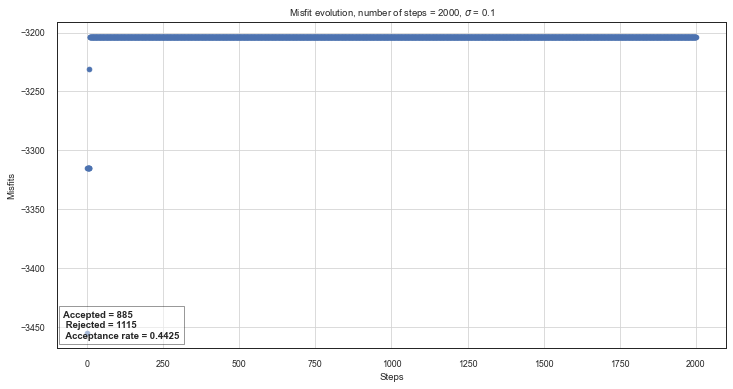

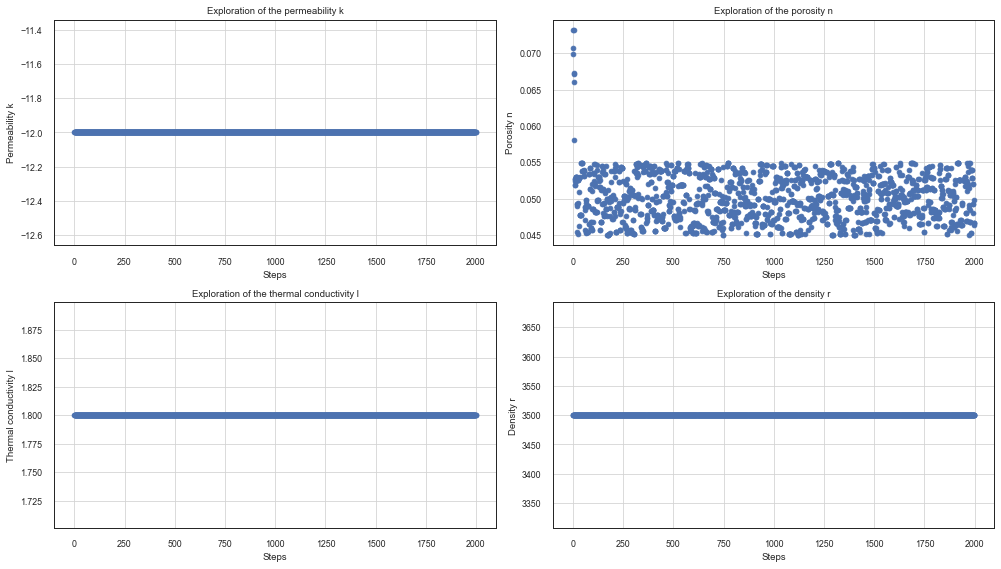

In [90]:
####################################################################
### RUN THE METROPOLIS-HASTINGS ALGORITHM FOR ONE PARAMETER ONLY ###
#################################################################### 

# For porosity n

sigma = 0.1
step = 2000
percentage_int = 0.04

k_0 = -12 # Goal : -12
n_0 = 0.08 # Goal : 0.05
l_0 = 1.8 # Goal : 1.8
r_0 = 3500 # Goal : 3500
m_0 = [k_0, n_0, l_0, r_0]

k_exp = [-15, -10]
n_exp = [0.01, 0.20]
l_exp = [0.5, 5]
r_exp = [1500, 5500]
m_exp = [k_exp, n_exp, l_exp, r_exp]

modele, l_misfit, accepted, rejected, alpha_l, rho_l = metropolis_one_para('n', m_0, m_exp,step,obs_temp,sigma,percentage_int)

plot_metropolis(step,sigma,l_misfit)

plot_exploration(step,sigma,modele)

#plot_metropolis_final(modele)

In [ ]:
####################################################################
### RUN THE METROPOLIS-HASTINGS ALGORITHM FOR ONE PARAMETER ONLY ###
#################################################################### 

# For thermal conductivity l

sigma = 1
step = 2000
percentage_int = 0.01

k_0 = -12 # Goal : -12
n_0 = 0.05 # Goal : 0.05
l_0 = 2.2 # Goal : 1.8
r_0 = 3500 # Goal : 3500
m_0 = [k_0, n_0, l_0, r_0]

k_exp = [-15, -10]
n_exp = [0.01, 0.20]
l_exp = [0.5, 5]
r_exp = [1500, 5500]
m_exp = [k_exp, n_exp, l_exp, r_exp]

modele, l_misfit, accepted, rejected, alpha_l, rho_l = metropolis_one_para('l', m_0, m_exp,step,obs_temp,sigma,percentage_int)

plot_metropolis(step,sigma,l_misfit)

plot_exploration(step,sigma,modele)

#plot_metropolis_final(modele)

In [ ]:
####################################################################
### RUN THE METROPOLIS-HASTINGS ALGORITHM FOR ONE PARAMETER ONLY ###
#################################################################### 

# For density r

sigma = 0.3 
step = 2000
percentage_int = 0.01

k_0 = -12 # Goal : -12
n_0 = 0.05 # Goal : 0.05
l_0 = 1.8 # Goal : 1.8
r_0 = 3000 # Goal : 3500
m_0 = [k_0, n_0, l_0, r_0]

k_exp = [-15, -10]
n_exp = [0.01, 0.20]
l_exp = [0.5, 5]
r_exp = [1500, 5500]
m_exp = [k_exp, n_exp, l_exp, r_exp]

modele, l_misfit, accepted, rejected, alpha_l, rho_l = metropolis_one_para('r', m_0, m_exp,step,obs_temp,sigma,percentage_int)

plot_metropolis(step,sigma,l_misfit)

plot_exploration(step,sigma,modele)

#plot_metropolis_final(modele)

  5%|▍         | 93/2000 [27:30<9:16:10, 17.50s/it] 